# Predicting Death in MIMIC3

## Data Loading

In [1]:
from numpy.random import seed
seed(2)

import os
import sys
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report

In [2]:
import keras
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute, Lambda
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [3]:
df = pd.read_csv(os.path.join('../mimic/data_processed', 'mimic_dataset_incomplete.csv'))

In [4]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'M').astype(int)

In [5]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

df_train, df_test = df_split(df)

In [6]:
# sanity check
df_test['HADM_ID'].isin(df_train['HADM_ID']).value_counts()

False    2844
Name: HADM_ID, dtype: int64

In [7]:
df_train['HADM_ID'].isin(df_test['HADM_ID']).value_counts()

False    12412
Name: HADM_ID, dtype: int64

In [8]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2'
]

In [9]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        maxshape = max(maxshape, point.values.shape)
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [10]:
X_train.shape

(2312, 63, 16)

## Dataset

### Histogram of Days

Don't cut to 14 days - want last day data before death for now

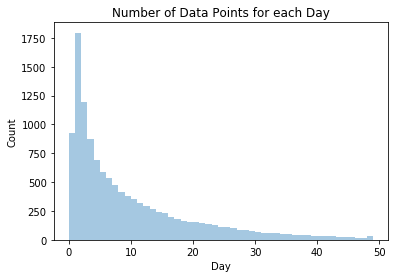

In [11]:
fig = sns.distplot(df_train[df_train.Day < 50]['Day'], bins=range(50), kde=False)
plt.title('Number of Data Points for each Day')
plt.ylabel('Count')
plt.show(fig)

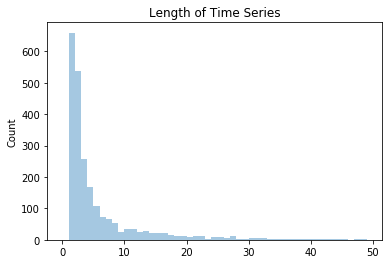

In [12]:
fig = sns.distplot([len(x) for x in lst_train if len(x) <= 50], bins=range(50), kde=False)
plt.title('Length of Time Series')
plt.ylabel('Count')
plt.show(fig)

In [13]:
# summary statistics
df_train['Day'].describe()

count    12412.000000
mean        10.494521
std         13.320318
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        131.000000
Name: Day, dtype: float64

In [14]:
# number of patients who died
df_train.groupby('HADM_ID').first()['DEATH'].value_counts()

0    1576
1     736
Name: DEATH, dtype: int64

In [15]:
1 - sum(Y_test) / len(Y_test)

0.707105719237435

In [16]:
# class weights
class_weight = {0: 1, 1: 2}

### Histogram of Outcomes for Each Feature
We want to see the distributions for each different numeric feature. This is best done as a histogram. You can see all of these histograms below.

HCO3, Age and Heart Rate appear to be the most separable. 

In [17]:
def plot_feature(col):
    died = []
    discharged = []

    for index, point in enumerate(lst_train):        
        if Y_train[index]:
            died.append(point[0, X_cols.index(col)])
        else:
            discharged.append(point[0, X_cols.index(col)])

    minimum = int(min(*died,*discharged))
    maximum = int(max(*died,*discharged))
    
    if minimum == 0 and maximum == 1:
        return
            
    sns.distplot(discharged, kde=False, bins=range(minimum, maximum), label="Discharged")
    fig = sns.distplot(died, kde=False, bins=range(minimum, maximum), label="Died")
    plt.title(f'Histogram for {col.title()}')
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    plt.show(fig)

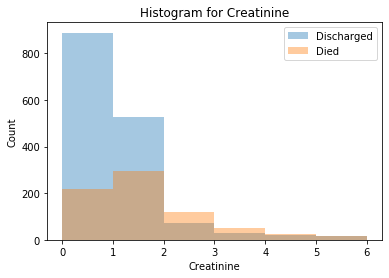

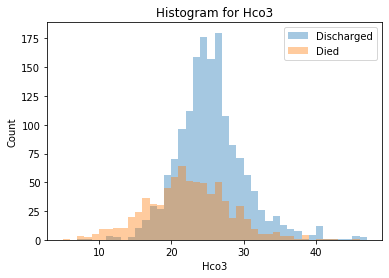

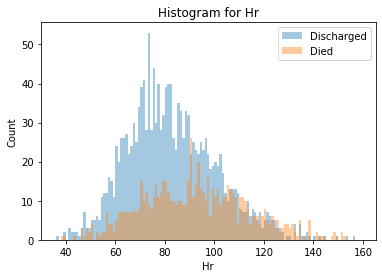

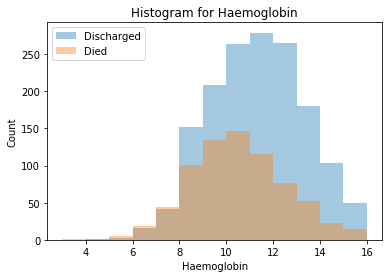

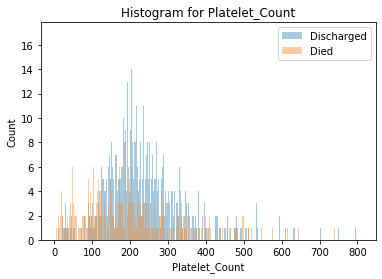

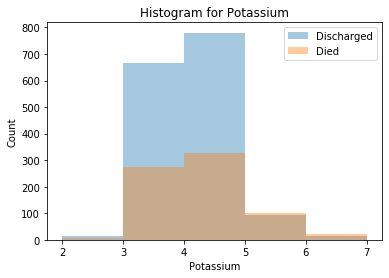

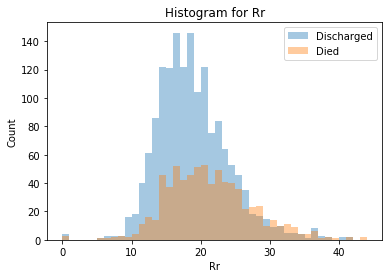

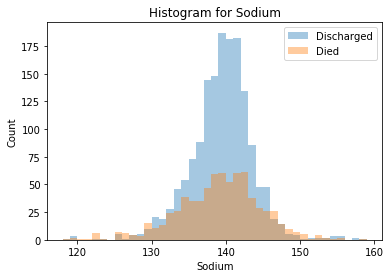

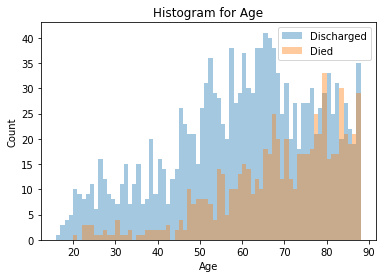

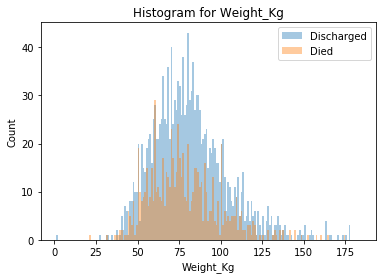

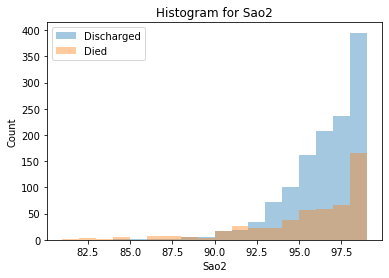

In [18]:
for col in X_cols:
    plot_feature(col)

### Histogram of Outcomes for each day

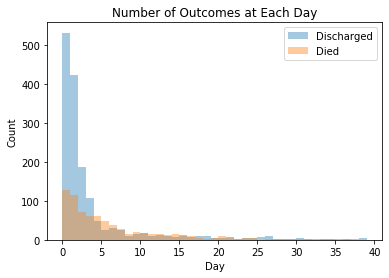

In [19]:
died = []
discharged = []

for index, point in enumerate(lst_train):
    if len(point) - 1 > 40:
        continue
        
    if Y_train[index]:
        died.append(len(point) - 1)
    else:
        discharged.append(len(point) - 1)
    
sns.distplot(discharged, kde=False, bins=range(40), label="Discharged")
fig = sns.distplot(died, kde=False, bins=range(40), label="Died")
plt.title('Number of Outcomes at Each Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.legend()
plt.show(fig)

### Correlation matrix

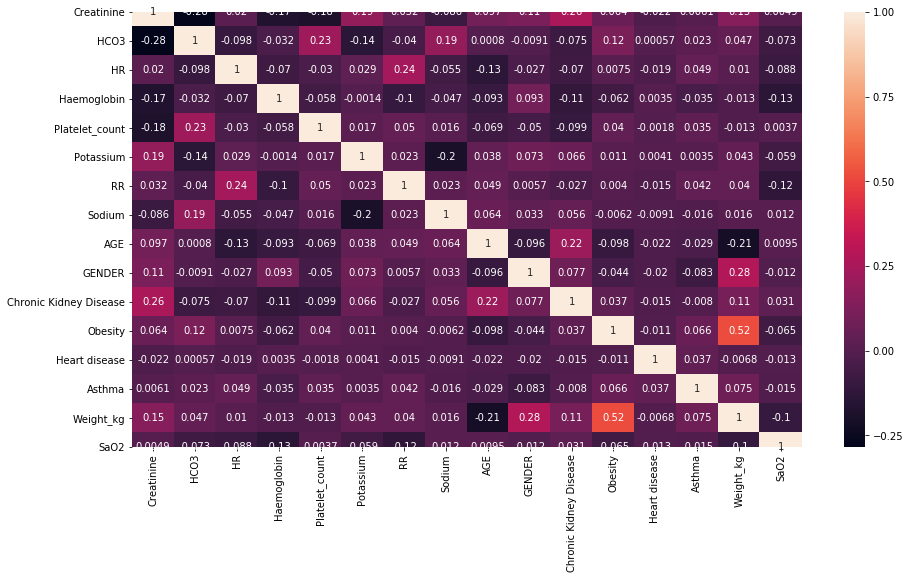

In [20]:
corrMatrix = df[X_cols].corr()

plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True)

### Create Model

Why 128 units?
Hypermarater search?
TODO

In [141]:
# https://gist.github.com/iridiumblue/622a9525189d48e9c00659fea269bfa4

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import initializers 
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
from tensorflow.keras import activations 
from tensorflow.keras import backend as K

class AttentionWithContext(Layer):
    """
        Attention operation, with a context/query vector, for temporal data.
        Supports Masking.
        Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
        "Hierarchical Attention Networks for Document Classification"
        by using a context vector to assist the attention
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(AttentionWithContext())
        """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False, **kwargs):

        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3
        input_shape_list = input_shape.as_list()

        self.W = self.add_weight(shape=((input_shape_list[-1], input_shape_list[-1])),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight(shape=(input_shape_list[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight(shape=(input_shape_list[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape.as_list())

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = tf.tensordot(x, self.W,axes=1)

        if self.bias:
            uit += self.b

        uit = activations.tanh(uit)
        # ait = K.dot(uit, self.u)
        ait = tf.tensordot(uit, self.u,axes=1)

        a = activations.exponential(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= tf.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
#         a /= tf.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            #TODO use TensorShape here, as done in the else statement.   I'm not sure
            # if this is returning a single tensor, or a list of two so leaving this undone for now.  Suspect this will
            # need to complete if using Sequential rather than Functional API
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return tf.TensorShape([input_shape[0].value,input_shape[-1].value])

In [142]:
# units - dimensionality of output space from LSTM
lstm_units = 128

input_layer = Input(shape=(None, len(X_cols))) 

# set states going into this LSTM application
# in order to use SHAP, need to pass on state
feedin_previous_output = Input(shape=(lstm_units)) 
feedin_cell_state = Input(shape=(lstm_units)) 

x = Masking(mask_value=0)(input_layer)
x = LSTM(lstm_units, return_sequences=True)(x, initial_state=[feedin_previous_output, feedin_cell_state])
x = AttentionWithContext()(x)
output = Dense(1, activation='sigmoid')(x) # binary output

model = Model(inputs=[input_layer, feedin_previous_output, feedin_cell_state],
              outputs=output)


In [143]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
# only optimize output from dense layer
model.compile(optimizer, loss=['binary_crossentropy', None, None], metrics=['acc'])

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           [(None, None, 16)]   0                                            
__________________________________________________________________________________________________
masking_11 (Masking)            (None, None, 16)     0           input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 128)]        0                                            
____________________________________________________________________________________________

In [97]:
def model_predict(x, h=None, c=None, state=False):
    """Wrapper function for running model predictions. 
    
    h: Input to the model, corresponds with `feedin_previous_output`.
        Set to None for default initialization
        
    c: Input to the model, corresponds with `feedin_cell_state`.
        Set to None for default initialization
        
    state: If True, return the state from the model. Otherwise, just return output.
    
    Returns: model output
    """
    
    if h is None:
        h = np.zeros((len(x), lstm_units))
        
    if c is None:
        c = np.zeros((len(x), lstm_units))

    if state:
        return model.predict([x, h, c])
    return model.predict([x, h, c])[0]

def model_evaluate(x, y):
    """Wrapper function to evaluate model accuracy on x and y. Returns accuracy."""
    
    return model.evaluate(x=[x, np.zeros((len(x), lstm_units)), np.zeros((len(x), lstm_units))],
                          y=y, verbose=False)

In [24]:
# default initial state is all zeros
zero = np.zeros((1,128))

In [25]:
model_predict(lst_test[0].reshape(1,-1,len(X_cols)))

array([[0.55405426]], dtype=float32)

In [26]:
lst_test[0].reshape(1,-1,len(X_cols)).shape

(1, 6, 16)

In [27]:
model_predict(lst_test[0][5].reshape(1,-1,len(X_cols)))

array([[0.46434006]], dtype=float32)

In [28]:
output, lstm_output, cell_state = model_predict(lst_test[0][:5].reshape(1,-1,len(X_cols)), state=True)
output

array([[0.59023786]], dtype=float32)

In [29]:
model_predict(lst_test[0][5].reshape(1,-1,len(X_cols)),h=lstm_output, c=cell_state)

array([[0.55405426]], dtype=float32)

THEY MATCH!!!!

In [30]:
X_train.shape

(2312, 63, 16)

In [ ]:
tf.config.experimental_run_functions_eagerly(True)

In [147]:
model.fit(x=[X_train, np.zeros((len(X_train), 128)), np.zeros((len(X_train), 128))],
          y=Y_train, class_weight=class_weight, epochs=50)

Epoch 1/50
73/73 [==============================] - ETA: 0s - loss: 0.3985 - acc: 0.875 - ETA: 4s - loss: 0.4269 - acc: 0.875 - ETA: 6s - loss: 0.4294 - acc: 0.895 - ETA: 7s - loss: 0.4556 - acc: 0.898 - ETA: 7s - loss: 0.4412 - acc: 0.887 - ETA: 7s - loss: 0.4360 - acc: 0.890 - ETA: 7s - loss: 0.4494 - acc: 0.888 - ETA: 8s - loss: 0.4654 - acc: 0.886 - ETA: 7s - loss: 0.4745 - acc: 0.885 - ETA: 7s - loss: 0.4884 - acc: 0.878 - ETA: 7s - loss: 0.4778 - acc: 0.875 - ETA: 7s - loss: 0.4734 - acc: 0.869 - ETA: 7s - loss: 0.4857 - acc: 0.858 - ETA: 7s - loss: 0.4817 - acc: 0.859 - ETA: 7s - loss: 0.4907 - acc: 0.854 - ETA: 7s - loss: 0.4985 - acc: 0.851 - ETA: 7s - loss: 0.5003 - acc: 0.845 - ETA: 7s - loss: 0.5033 - acc: 0.847 - ETA: 7s - loss: 0.5074 - acc: 0.843 - ETA: 7s - loss: 0.5055 - acc: 0.845 - ETA: 6s - loss: 0.5065 - acc: 0.848 - ETA: 6s - loss: 0.5082 - acc: 0.848 - ETA: 6s - loss: 0.4990 - acc: 0.851 - ETA: 6s - loss: 0.5029 - acc: 0.851 - ETA: 6s - loss: 0.4991 - acc: 0.853 

73/73 [==============================] - ETA: 0s - loss: 0.6452 - acc: 0.843 - ETA: 4s - loss: 0.5831 - acc: 0.796 - ETA: 6s - loss: 0.5172 - acc: 0.812 - ETA: 7s - loss: 0.5352 - acc: 0.812 - ETA: 7s - loss: 0.5237 - acc: 0.825 - ETA: 7s - loss: 0.4906 - acc: 0.833 - ETA: 7s - loss: 0.5154 - acc: 0.834 - ETA: 7s - loss: 0.5594 - acc: 0.828 - ETA: 7s - loss: 0.5395 - acc: 0.833 - ETA: 7s - loss: 0.5303 - acc: 0.840 - ETA: 7s - loss: 0.5026 - acc: 0.855 - ETA: 7s - loss: 0.4952 - acc: 0.859 - ETA: 7s - loss: 0.4916 - acc: 0.858 - ETA: 7s - loss: 0.4819 - acc: 0.861 - ETA: 7s - loss: 0.4845 - acc: 0.862 - ETA: 7s - loss: 0.4815 - acc: 0.867 - ETA: 7s - loss: 0.4828 - acc: 0.860 - ETA: 7s - loss: 0.4842 - acc: 0.862 - ETA: 7s - loss: 0.4872 - acc: 0.858 - ETA: 7s - loss: 0.4923 - acc: 0.857 - ETA: 6s - loss: 0.4882 - acc: 0.860 - ETA: 6s - loss: 0.4870 - acc: 0.859 - ETA: 6s - loss: 0.4838 - acc: 0.860 - ETA: 6s - loss: 0.4841 - acc: 0.859 - ETA: 6s - loss: 0.4756 - acc: 0.861 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3245 - acc: 0.875 - ETA: 4s - loss: 0.4375 - acc: 0.828 - ETA: 6s - loss: 0.4592 - acc: 0.822 - ETA: 7s - loss: 0.4745 - acc: 0.843 - ETA: 7s - loss: 0.4463 - acc: 0.862 - ETA: 7s - loss: 0.4445 - acc: 0.869 - ETA: 8s - loss: 0.4552 - acc: 0.861 - ETA: 7s - loss: 0.4624 - acc: 0.855 - ETA: 7s - loss: 0.4714 - acc: 0.850 - ETA: 7s - loss: 0.4781 - acc: 0.850 - ETA: 7s - loss: 0.4718 - acc: 0.852 - ETA: 12s - loss: 0.4765 - acc: 0.85 - ETA: 12s - loss: 0.4805 - acc: 0.85 - ETA: 11s - loss: 0.4920 - acc: 0.84 - ETA: 11s - loss: 0.5065 - acc: 0.84 - ETA: 11s - loss: 0.5013 - acc: 0.84 - ETA: 10s - loss: 0.5011 - acc: 0.84 - ETA: 10s - loss: 0.4957 - acc: 0.85 - ETA: 9s - loss: 0.5103 - acc: 0.8454 - ETA: 9s - loss: 0.5153 - acc: 0.840 - ETA: 9s - loss: 0.5155 - acc: 0.837 - ETA: 9s - loss: 0.5128 - acc: 0.836 - ETA: 8s - loss: 0.5201 - acc: 0.834 - ETA: 8s - loss: 0.5189 - acc: 0.832 - ETA: 8s - loss: 0.5232 - acc: 0.828 - ETA: 8s 

73/73 [==============================] - ETA: 0s - loss: 0.3259 - acc: 0.875 - ETA: 4s - loss: 0.3720 - acc: 0.875 - ETA: 6s - loss: 0.3977 - acc: 0.885 - ETA: 7s - loss: 0.4236 - acc: 0.867 - ETA: 7s - loss: 0.4487 - acc: 0.862 - ETA: 7s - loss: 0.4909 - acc: 0.843 - ETA: 7s - loss: 0.4799 - acc: 0.848 - ETA: 7s - loss: 0.4555 - acc: 0.855 - ETA: 7s - loss: 0.4548 - acc: 0.843 - ETA: 7s - loss: 0.4582 - acc: 0.843 - ETA: 7s - loss: 0.4682 - acc: 0.838 - ETA: 7s - loss: 0.4765 - acc: 0.841 - ETA: 7s - loss: 0.4811 - acc: 0.841 - ETA: 7s - loss: 0.4820 - acc: 0.846 - ETA: 7s - loss: 0.4676 - acc: 0.850 - ETA: 7s - loss: 0.4729 - acc: 0.851 - ETA: 7s - loss: 0.4818 - acc: 0.843 - ETA: 7s - loss: 0.4808 - acc: 0.842 - ETA: 7s - loss: 0.5031 - acc: 0.840 - ETA: 6s - loss: 0.4998 - acc: 0.840 - ETA: 6s - loss: 0.5030 - acc: 0.843 - ETA: 6s - loss: 0.5006 - acc: 0.845 - ETA: 6s - loss: 0.5014 - acc: 0.842 - ETA: 6s - loss: 0.5097 - acc: 0.837 - ETA: 6s - loss: 0.5095 - acc: 0.840 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.5741 - acc: 0.875 - ETA: 5s - loss: 0.4319 - acc: 0.921 - ETA: 6s - loss: 0.5918 - acc: 0.875 - ETA: 8s - loss: 0.5720 - acc: 0.867 - ETA: 8s - loss: 0.5634 - acc: 0.862 - ETA: 9s - loss: 0.5482 - acc: 0.864 - ETA: 9s - loss: 0.5432 - acc: 0.857 - ETA: 9s - loss: 0.5323 - acc: 0.863 - ETA: 9s - loss: 0.5056 - acc: 0.868 - ETA: 9s - loss: 0.4801 - acc: 0.878 - ETA: 8s - loss: 0.4916 - acc: 0.877 - ETA: 8s - loss: 0.4953 - acc: 0.864 - ETA: 8s - loss: 0.4948 - acc: 0.863 - ETA: 8s - loss: 0.4939 - acc: 0.861 - ETA: 8s - loss: 0.5153 - acc: 0.850 - ETA: 8s - loss: 0.5196 - acc: 0.847 - ETA: 8s - loss: 0.5239 - acc: 0.841 - ETA: 8s - loss: 0.5131 - acc: 0.843 - ETA: 7s - loss: 0.5071 - acc: 0.848 - ETA: 7s - loss: 0.4988 - acc: 0.853 - ETA: 7s - loss: 0.4877 - acc: 0.855 - ETA: 7s - loss: 0.4887 - acc: 0.850 - ETA: 7s - loss: 0.4900 - acc: 0.849 - ETA: 7s - loss: 0.4875 - acc: 0.845 - ETA: 6s - loss: 0.4828 - acc: 0.848 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3859 - acc: 0.906 - ETA: 4s - loss: 0.4031 - acc: 0.890 - ETA: 6s - loss: 0.4831 - acc: 0.843 - ETA: 7s - loss: 0.4416 - acc: 0.867 - ETA: 7s - loss: 0.4300 - acc: 0.868 - ETA: 7s - loss: 0.4351 - acc: 0.875 - ETA: 7s - loss: 0.4578 - acc: 0.861 - ETA: 7s - loss: 0.4599 - acc: 0.863 - ETA: 7s - loss: 0.4582 - acc: 0.864 - ETA: 7s - loss: 0.4530 - acc: 0.862 - ETA: 7s - loss: 0.4581 - acc: 0.858 - ETA: 7s - loss: 0.4657 - acc: 0.856 - ETA: 7s - loss: 0.4672 - acc: 0.863 - ETA: 7s - loss: 0.4728 - acc: 0.859 - ETA: 7s - loss: 0.4809 - acc: 0.860 - ETA: 7s - loss: 0.4881 - acc: 0.857 - ETA: 7s - loss: 0.4774 - acc: 0.862 - ETA: 7s - loss: 0.4765 - acc: 0.862 - ETA: 7s - loss: 0.4725 - acc: 0.865 - ETA: 7s - loss: 0.4769 - acc: 0.859 - ETA: 6s - loss: 0.4759 - acc: 0.860 - ETA: 6s - loss: 0.4793 - acc: 0.859 - ETA: 6s - loss: 0.4907 - acc: 0.853 - ETA: 6s - loss: 0.4890 - acc: 0.854 - ETA: 6s - loss: 0.4885 - acc: 0.852 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3698 - acc: 0.843 - ETA: 5s - loss: 0.3793 - acc: 0.890 - ETA: 6s - loss: 0.4865 - acc: 0.885 - ETA: 7s - loss: 0.4718 - acc: 0.882 - ETA: 7s - loss: 0.4932 - acc: 0.875 - ETA: 7s - loss: 0.5196 - acc: 0.869 - ETA: 8s - loss: 0.4973 - acc: 0.870 - ETA: 7s - loss: 0.5176 - acc: 0.859 - ETA: 8s - loss: 0.4975 - acc: 0.861 - ETA: 8s - loss: 0.4908 - acc: 0.859 - ETA: 7s - loss: 0.4901 - acc: 0.852 - ETA: 7s - loss: 0.4788 - acc: 0.859 - ETA: 7s - loss: 0.4788 - acc: 0.855 - ETA: 7s - loss: 0.4774 - acc: 0.857 - ETA: 7s - loss: 0.4755 - acc: 0.858 - ETA: 7s - loss: 0.4875 - acc: 0.853 - ETA: 7s - loss: 0.4828 - acc: 0.854 - ETA: 7s - loss: 0.4729 - acc: 0.857 - ETA: 7s - loss: 0.4703 - acc: 0.858 - ETA: 7s - loss: 0.4792 - acc: 0.857 - ETA: 7s - loss: 0.4794 - acc: 0.855 - ETA: 7s - loss: 0.4812 - acc: 0.858 - ETA: 6s - loss: 0.4779 - acc: 0.861 - ETA: 6s - loss: 0.4719 - acc: 0.863 - ETA: 6s - loss: 0.4636 - acc: 0.867 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4121 - acc: 0.843 - ETA: 4s - loss: 0.5689 - acc: 0.781 - ETA: 6s - loss: 0.5934 - acc: 0.802 - ETA: 7s - loss: 0.5721 - acc: 0.820 - ETA: 7s - loss: 0.5624 - acc: 0.812 - ETA: 7s - loss: 0.5484 - acc: 0.812 - ETA: 7s - loss: 0.5420 - acc: 0.812 - ETA: 7s - loss: 0.5642 - acc: 0.812 - ETA: 7s - loss: 0.5432 - acc: 0.822 - ETA: 7s - loss: 0.5428 - acc: 0.821 - ETA: 7s - loss: 0.5255 - acc: 0.826 - ETA: 7s - loss: 0.5218 - acc: 0.833 - ETA: 7s - loss: 0.5258 - acc: 0.829 - ETA: 7s - loss: 0.5276 - acc: 0.830 - ETA: 7s - loss: 0.5163 - acc: 0.835 - ETA: 7s - loss: 0.5005 - acc: 0.843 - ETA: 7s - loss: 0.4978 - acc: 0.843 - ETA: 7s - loss: 0.4893 - acc: 0.847 - ETA: 7s - loss: 0.4781 - acc: 0.853 - ETA: 6s - loss: 0.4867 - acc: 0.856 - ETA: 6s - loss: 0.4993 - acc: 0.851 - ETA: 6s - loss: 0.4948 - acc: 0.852 - ETA: 6s - loss: 0.4937 - acc: 0.854 - ETA: 6s - loss: 0.4916 - acc: 0.854 - ETA: 6s - loss: 0.4872 - acc: 0.855 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4008 - acc: 0.843 - ETA: 5s - loss: 0.3643 - acc: 0.859 - ETA: 6s - loss: 0.4047 - acc: 0.843 - ETA: 7s - loss: 0.4122 - acc: 0.859 - ETA: 7s - loss: 0.4148 - acc: 0.868 - ETA: 7s - loss: 0.4721 - acc: 0.859 - ETA: 8s - loss: 0.4975 - acc: 0.848 - ETA: 8s - loss: 0.4841 - acc: 0.855 - ETA: 8s - loss: 0.4758 - acc: 0.861 - ETA: 8s - loss: 0.4594 - acc: 0.865 - ETA: 8s - loss: 0.4496 - acc: 0.866 - ETA: 7s - loss: 0.4506 - acc: 0.864 - ETA: 7s - loss: 0.4624 - acc: 0.860 - ETA: 7s - loss: 0.4705 - acc: 0.857 - ETA: 7s - loss: 0.4712 - acc: 0.856 - ETA: 7s - loss: 0.4700 - acc: 0.855 - ETA: 7s - loss: 0.4815 - acc: 0.854 - ETA: 7s - loss: 0.4895 - acc: 0.849 - ETA: 7s - loss: 0.4990 - acc: 0.848 - ETA: 7s - loss: 0.4947 - acc: 0.851 - ETA: 7s - loss: 0.4996 - acc: 0.851 - ETA: 6s - loss: 0.5011 - acc: 0.852 - ETA: 6s - loss: 0.5017 - acc: 0.849 - ETA: 6s - loss: 0.5058 - acc: 0.843 - ETA: 6s - loss: 0.5049 - acc: 0.841 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.5671 - acc: 0.875 - ETA: 4s - loss: 0.6605 - acc: 0.812 - ETA: 6s - loss: 0.7047 - acc: 0.791 - ETA: 7s - loss: 0.6063 - acc: 0.835 - ETA: 7s - loss: 0.5528 - acc: 0.850 - ETA: 7s - loss: 0.5627 - acc: 0.838 - ETA: 8s - loss: 0.5386 - acc: 0.843 - ETA: 7s - loss: 0.5336 - acc: 0.839 - ETA: 7s - loss: 0.5357 - acc: 0.840 - ETA: 7s - loss: 0.5295 - acc: 0.840 - ETA: 7s - loss: 0.5291 - acc: 0.838 - ETA: 7s - loss: 0.5229 - acc: 0.843 - ETA: 7s - loss: 0.5351 - acc: 0.834 - ETA: 7s - loss: 0.5341 - acc: 0.832 - ETA: 7s - loss: 0.5618 - acc: 0.829 - ETA: 7s - loss: 0.5461 - acc: 0.835 - ETA: 7s - loss: 0.5318 - acc: 0.840 - ETA: 7s - loss: 0.5254 - acc: 0.840 - ETA: 7s - loss: 0.5301 - acc: 0.840 - ETA: 7s - loss: 0.5263 - acc: 0.842 - ETA: 6s - loss: 0.5232 - acc: 0.843 - ETA: 6s - loss: 0.5196 - acc: 0.843 - ETA: 6s - loss: 0.5149 - acc: 0.843 - ETA: 6s - loss: 0.5050 - acc: 0.846 - ETA: 6s - loss: 0.5050 - acc: 0.846 - ETA: 8s -

73/73 [==============================] - ETA: 0s - loss: 0.4609 - acc: 0.875 - ETA: 4s - loss: 0.4828 - acc: 0.843 - ETA: 6s - loss: 0.4782 - acc: 0.864 - ETA: 7s - loss: 0.5123 - acc: 0.843 - ETA: 7s - loss: 0.5196 - acc: 0.843 - ETA: 7s - loss: 0.5266 - acc: 0.854 - ETA: 7s - loss: 0.5217 - acc: 0.852 - ETA: 7s - loss: 0.5187 - acc: 0.847 - ETA: 7s - loss: 0.5230 - acc: 0.840 - ETA: 7s - loss: 0.5188 - acc: 0.840 - ETA: 7s - loss: 0.5029 - acc: 0.849 - ETA: 7s - loss: 0.4904 - acc: 0.854 - ETA: 7s - loss: 0.4887 - acc: 0.851 - ETA: 7s - loss: 0.4775 - acc: 0.850 - ETA: 7s - loss: 0.4666 - acc: 0.856 - ETA: 7s - loss: 0.4570 - acc: 0.859 - ETA: 7s - loss: 0.4505 - acc: 0.860 - ETA: 7s - loss: 0.4494 - acc: 0.861 - ETA: 7s - loss: 0.4534 - acc: 0.860 - ETA: 7s - loss: 0.4650 - acc: 0.856 - ETA: 6s - loss: 0.4594 - acc: 0.858 - ETA: 6s - loss: 0.4555 - acc: 0.858 - ETA: 6s - loss: 0.4587 - acc: 0.853 - ETA: 6s - loss: 0.4692 - acc: 0.850 - ETA: 6s - loss: 0.4754 - acc: 0.848 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.5994 - acc: 0.843 - ETA: 4s - loss: 0.4532 - acc: 0.890 - ETA: 6s - loss: 0.4633 - acc: 0.895 - ETA: 7s - loss: 0.4243 - acc: 0.906 - ETA: 7s - loss: 0.4145 - acc: 0.906 - ETA: 7s - loss: 0.4137 - acc: 0.895 - ETA: 8s - loss: 0.4338 - acc: 0.879 - ETA: 8s - loss: 0.4568 - acc: 0.867 - ETA: 8s - loss: 0.4374 - acc: 0.871 - ETA: 8s - loss: 0.4300 - acc: 0.878 - ETA: 7s - loss: 0.4537 - acc: 0.863 - ETA: 7s - loss: 0.4431 - acc: 0.862 - ETA: 7s - loss: 0.4514 - acc: 0.853 - ETA: 7s - loss: 0.4392 - acc: 0.857 - ETA: 7s - loss: 0.4479 - acc: 0.856 - ETA: 7s - loss: 0.4472 - acc: 0.853 - ETA: 7s - loss: 0.4517 - acc: 0.849 - ETA: 7s - loss: 0.4517 - acc: 0.852 - ETA: 7s - loss: 0.4469 - acc: 0.850 - ETA: 7s - loss: 0.4505 - acc: 0.848 - ETA: 6s - loss: 0.4409 - acc: 0.851 - ETA: 6s - loss: 0.4394 - acc: 0.852 - ETA: 6s - loss: 0.4453 - acc: 0.850 - ETA: 6s - loss: 0.4416 - acc: 0.852 - ETA: 6s - loss: 0.4390 - acc: 0.855 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3598 - acc: 0.968 - ETA: 4s - loss: 0.4563 - acc: 0.890 - ETA: 6s - loss: 0.5806 - acc: 0.812 - ETA: 7s - loss: 0.5537 - acc: 0.796 - ETA: 7s - loss: 0.5439 - acc: 0.806 - ETA: 7s - loss: 0.5505 - acc: 0.812 - ETA: 7s - loss: 0.5609 - acc: 0.808 - ETA: 7s - loss: 0.5534 - acc: 0.804 - ETA: 7s - loss: 0.5394 - acc: 0.805 - ETA: 7s - loss: 0.5317 - acc: 0.803 - ETA: 7s - loss: 0.5195 - acc: 0.804 - ETA: 7s - loss: 0.5065 - acc: 0.809 - ETA: 7s - loss: 0.5009 - acc: 0.817 - ETA: 7s - loss: 0.4976 - acc: 0.819 - ETA: 7s - loss: 0.5000 - acc: 0.816 - ETA: 7s - loss: 0.5175 - acc: 0.812 - ETA: 7s - loss: 0.5243 - acc: 0.810 - ETA: 7s - loss: 0.5275 - acc: 0.807 - ETA: 6s - loss: 0.5293 - acc: 0.807 - ETA: 6s - loss: 0.5308 - acc: 0.803 - ETA: 6s - loss: 0.5231 - acc: 0.806 - ETA: 6s - loss: 0.5178 - acc: 0.805 - ETA: 6s - loss: 0.5157 - acc: 0.807 - ETA: 6s - loss: 0.5297 - acc: 0.802 - ETA: 6s - loss: 0.5309 - acc: 0.803 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.7932 - acc: 0.718 - ETA: 4s - loss: 0.6079 - acc: 0.781 - ETA: 6s - loss: 0.5727 - acc: 0.791 - ETA: 7s - loss: 0.4930 - acc: 0.828 - ETA: 7s - loss: 0.4879 - acc: 0.837 - ETA: 7s - loss: 0.5207 - acc: 0.833 - ETA: 7s - loss: 0.4991 - acc: 0.848 - ETA: 7s - loss: 0.4955 - acc: 0.847 - ETA: 7s - loss: 0.5018 - acc: 0.850 - ETA: 7s - loss: 0.4875 - acc: 0.853 - ETA: 7s - loss: 0.4859 - acc: 0.852 - ETA: 7s - loss: 0.4986 - acc: 0.851 - ETA: 7s - loss: 0.5121 - acc: 0.841 - ETA: 7s - loss: 0.5095 - acc: 0.837 - ETA: 7s - loss: 0.5079 - acc: 0.837 - ETA: 7s - loss: 0.4919 - acc: 0.847 - ETA: 7s - loss: 0.4957 - acc: 0.849 - ETA: 7s - loss: 0.5001 - acc: 0.849 - ETA: 6s - loss: 0.4977 - acc: 0.850 - ETA: 6s - loss: 0.4945 - acc: 0.850 - ETA: 6s - loss: 0.4910 - acc: 0.851 - ETA: 6s - loss: 0.4855 - acc: 0.852 - ETA: 6s - loss: 0.4772 - acc: 0.851 - ETA: 6s - loss: 0.4757 - acc: 0.851 - ETA: 6s - loss: 0.4798 - acc: 0.848 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4594 - acc: 0.843 - ETA: 4s - loss: 0.4539 - acc: 0.875 - ETA: 6s - loss: 0.4683 - acc: 0.864 - ETA: 7s - loss: 0.4713 - acc: 0.867 - ETA: 7s - loss: 0.4599 - acc: 0.868 - ETA: 7s - loss: 0.4718 - acc: 0.875 - ETA: 7s - loss: 0.5033 - acc: 0.866 - ETA: 7s - loss: 0.5169 - acc: 0.855 - ETA: 7s - loss: 0.5231 - acc: 0.854 - ETA: 7s - loss: 0.4895 - acc: 0.862 - ETA: 7s - loss: 0.4908 - acc: 0.860 - ETA: 7s - loss: 0.4935 - acc: 0.864 - ETA: 7s - loss: 0.4818 - acc: 0.865 - ETA: 7s - loss: 0.4681 - acc: 0.866 - ETA: 7s - loss: 0.4645 - acc: 0.860 - ETA: 7s - loss: 0.4699 - acc: 0.859 - ETA: 7s - loss: 0.4579 - acc: 0.860 - ETA: 7s - loss: 0.4581 - acc: 0.862 - ETA: 7s - loss: 0.4542 - acc: 0.865 - ETA: 6s - loss: 0.4561 - acc: 0.860 - ETA: 6s - loss: 0.4518 - acc: 0.860 - ETA: 6s - loss: 0.4488 - acc: 0.860 - ETA: 6s - loss: 0.4426 - acc: 0.861 - ETA: 6s - loss: 0.4353 - acc: 0.864 - ETA: 6s - loss: 0.4397 - acc: 0.862 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.6146 - acc: 0.781 - ETA: 5s - loss: 0.4848 - acc: 0.859 - ETA: 7s - loss: 0.4636 - acc: 0.854 - ETA: 8s - loss: 0.4582 - acc: 0.835 - ETA: 8s - loss: 0.4383 - acc: 0.850 - ETA: 8s - loss: 0.4232 - acc: 0.864 - ETA: 8s - loss: 0.3941 - acc: 0.879 - ETA: 8s - loss: 0.4189 - acc: 0.871 - ETA: 8s - loss: 0.4186 - acc: 0.875 - ETA: 8s - loss: 0.4353 - acc: 0.865 - ETA: 8s - loss: 0.4272 - acc: 0.869 - ETA: 8s - loss: 0.4118 - acc: 0.875 - ETA: 8s - loss: 0.4084 - acc: 0.875 - ETA: 7s - loss: 0.4178 - acc: 0.868 - ETA: 7s - loss: 0.4133 - acc: 0.872 - ETA: 7s - loss: 0.4096 - acc: 0.875 - ETA: 7s - loss: 0.4245 - acc: 0.867 - ETA: 7s - loss: 0.4300 - acc: 0.868 - ETA: 7s - loss: 0.4286 - acc: 0.870 - ETA: 7s - loss: 0.4304 - acc: 0.871 - ETA: 7s - loss: 0.4391 - acc: 0.869 - ETA: 6s - loss: 0.4370 - acc: 0.867 - ETA: 6s - loss: 0.4347 - acc: 0.869 - ETA: 6s - loss: 0.4379 - acc: 0.868 - ETA: 6s - loss: 0.4410 - acc: 0.867 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4721 - acc: 0.843 - ETA: 4s - loss: 0.3830 - acc: 0.859 - ETA: 6s - loss: 0.3839 - acc: 0.864 - ETA: 7s - loss: 0.3573 - acc: 0.882 - ETA: 7s - loss: 0.3748 - acc: 0.875 - ETA: 7s - loss: 0.3960 - acc: 0.864 - ETA: 7s - loss: 0.3986 - acc: 0.870 - ETA: 7s - loss: 0.4012 - acc: 0.859 - ETA: 7s - loss: 0.3972 - acc: 0.861 - ETA: 7s - loss: 0.4012 - acc: 0.856 - ETA: 7s - loss: 0.4171 - acc: 0.858 - ETA: 7s - loss: 0.4364 - acc: 0.851 - ETA: 7s - loss: 0.4593 - acc: 0.848 - ETA: 7s - loss: 0.4459 - acc: 0.857 - ETA: 7s - loss: 0.4405 - acc: 0.858 - ETA: 7s - loss: 0.4489 - acc: 0.855 - ETA: 7s - loss: 0.4525 - acc: 0.854 - ETA: 7s - loss: 0.4468 - acc: 0.854 - ETA: 6s - loss: 0.4388 - acc: 0.855 - ETA: 6s - loss: 0.4298 - acc: 0.859 - ETA: 6s - loss: 0.4323 - acc: 0.857 - ETA: 6s - loss: 0.4345 - acc: 0.860 - ETA: 6s - loss: 0.4400 - acc: 0.860 - ETA: 6s - loss: 0.4400 - acc: 0.862 - ETA: 6s - loss: 0.4532 - acc: 0.856 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4480 - acc: 0.812 - ETA: 4s - loss: 0.3804 - acc: 0.890 - ETA: 6s - loss: 0.4623 - acc: 0.854 - ETA: 7s - loss: 0.4493 - acc: 0.859 - ETA: 7s - loss: 0.4437 - acc: 0.868 - ETA: 7s - loss: 0.4456 - acc: 0.864 - ETA: 7s - loss: 0.4287 - acc: 0.870 - ETA: 7s - loss: 0.4152 - acc: 0.878 - ETA: 7s - loss: 0.4063 - acc: 0.881 - ETA: 7s - loss: 0.4046 - acc: 0.881 - ETA: 7s - loss: 0.3933 - acc: 0.883 - ETA: 7s - loss: 0.4121 - acc: 0.875 - ETA: 7s - loss: 0.4309 - acc: 0.872 - ETA: 7s - loss: 0.4350 - acc: 0.872 - ETA: 7s - loss: 0.4211 - acc: 0.879 - ETA: 7s - loss: 0.4263 - acc: 0.873 - ETA: 7s - loss: 0.4258 - acc: 0.869 - ETA: 7s - loss: 0.4260 - acc: 0.868 - ETA: 7s - loss: 0.4209 - acc: 0.870 - ETA: 6s - loss: 0.4240 - acc: 0.868 - ETA: 6s - loss: 0.4286 - acc: 0.866 - ETA: 6s - loss: 0.4252 - acc: 0.866 - ETA: 6s - loss: 0.4354 - acc: 0.862 - ETA: 6s - loss: 0.4335 - acc: 0.864 - ETA: 6s - loss: 0.4291 - acc: 0.865 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3093 - acc: 0.937 - ETA: 4s - loss: 0.2867 - acc: 0.937 - ETA: 6s - loss: 0.3221 - acc: 0.927 - ETA: 7s - loss: 0.3490 - acc: 0.914 - ETA: 7s - loss: 0.3863 - acc: 0.900 - ETA: 7s - loss: 0.4239 - acc: 0.895 - ETA: 8s - loss: 0.4116 - acc: 0.901 - ETA: 8s - loss: 0.4176 - acc: 0.906 - ETA: 8s - loss: 0.4244 - acc: 0.902 - ETA: 8s - loss: 0.4123 - acc: 0.900 - ETA: 7s - loss: 0.3944 - acc: 0.909 - ETA: 7s - loss: 0.3836 - acc: 0.911 - ETA: 7s - loss: 0.3907 - acc: 0.908 - ETA: 7s - loss: 0.3810 - acc: 0.908 - ETA: 7s - loss: 0.3746 - acc: 0.908 - ETA: 7s - loss: 0.3898 - acc: 0.904 - ETA: 7s - loss: 0.3872 - acc: 0.906 - ETA: 7s - loss: 0.3928 - acc: 0.906 - ETA: 7s - loss: 0.4076 - acc: 0.901 - ETA: 7s - loss: 0.4005 - acc: 0.904 - ETA: 6s - loss: 0.4144 - acc: 0.898 - ETA: 6s - loss: 0.4147 - acc: 0.897 - ETA: 6s - loss: 0.4157 - acc: 0.895 - ETA: 6s - loss: 0.4133 - acc: 0.893 - ETA: 6s - loss: 0.4114 - acc: 0.892 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4317 - acc: 0.937 - ETA: 4s - loss: 0.5943 - acc: 0.875 - ETA: 6s - loss: 0.5868 - acc: 0.843 - ETA: 7s - loss: 0.5372 - acc: 0.859 - ETA: 7s - loss: 0.5300 - acc: 0.856 - ETA: 7s - loss: 0.5168 - acc: 0.864 - ETA: 7s - loss: 0.5449 - acc: 0.852 - ETA: 8s - loss: 0.5264 - acc: 0.859 - ETA: 8s - loss: 0.5150 - acc: 0.857 - ETA: 8s - loss: 0.5087 - acc: 0.856 - ETA: 7s - loss: 0.5134 - acc: 0.849 - ETA: 7s - loss: 0.5078 - acc: 0.846 - ETA: 7s - loss: 0.5038 - acc: 0.846 - ETA: 7s - loss: 0.5105 - acc: 0.834 - ETA: 7s - loss: 0.5231 - acc: 0.827 - ETA: 7s - loss: 0.5218 - acc: 0.822 - ETA: 7s - loss: 0.5115 - acc: 0.827 - ETA: 7s - loss: 0.5103 - acc: 0.826 - ETA: 7s - loss: 0.5116 - acc: 0.828 - ETA: 7s - loss: 0.5089 - acc: 0.828 - ETA: 6s - loss: 0.5101 - acc: 0.830 - ETA: 6s - loss: 0.5013 - acc: 0.833 - ETA: 6s - loss: 0.5017 - acc: 0.835 - ETA: 6s - loss: 0.4995 - acc: 0.837 - ETA: 6s - loss: 0.4952 - acc: 0.837 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.6826 - acc: 0.718 - ETA: 4s - loss: 0.5895 - acc: 0.781 - ETA: 6s - loss: 0.5156 - acc: 0.822 - ETA: 7s - loss: 0.4866 - acc: 0.828 - ETA: 7s - loss: 0.4541 - acc: 0.843 - ETA: 7s - loss: 0.4806 - acc: 0.838 - ETA: 8s - loss: 0.4891 - acc: 0.848 - ETA: 7s - loss: 0.4869 - acc: 0.851 - ETA: 8s - loss: 0.4801 - acc: 0.854 - ETA: 8s - loss: 0.4661 - acc: 0.856 - ETA: 7s - loss: 0.4657 - acc: 0.860 - ETA: 7s - loss: 0.4669 - acc: 0.859 - ETA: 7s - loss: 0.4830 - acc: 0.853 - ETA: 7s - loss: 0.4755 - acc: 0.850 - ETA: 7s - loss: 0.4852 - acc: 0.841 - ETA: 7s - loss: 0.4763 - acc: 0.843 - ETA: 7s - loss: 0.4744 - acc: 0.845 - ETA: 7s - loss: 0.4764 - acc: 0.845 - ETA: 7s - loss: 0.4713 - acc: 0.848 - ETA: 7s - loss: 0.4755 - acc: 0.846 - ETA: 6s - loss: 0.4762 - acc: 0.842 - ETA: 6s - loss: 0.4737 - acc: 0.842 - ETA: 6s - loss: 0.4714 - acc: 0.845 - ETA: 6s - loss: 0.4739 - acc: 0.843 - ETA: 6s - loss: 0.4819 - acc: 0.836 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.2378 - acc: 0.937 - ETA: 4s - loss: 0.2696 - acc: 0.937 - ETA: 6s - loss: 0.3466 - acc: 0.916 - ETA: 7s - loss: 0.3315 - acc: 0.906 - ETA: 7s - loss: 0.3648 - acc: 0.887 - ETA: 7s - loss: 0.4051 - acc: 0.869 - ETA: 7s - loss: 0.3973 - acc: 0.870 - ETA: 7s - loss: 0.3880 - acc: 0.878 - ETA: 7s - loss: 0.3932 - acc: 0.878 - ETA: 7s - loss: 0.4102 - acc: 0.871 - ETA: 7s - loss: 0.4106 - acc: 0.877 - ETA: 7s - loss: 0.4151 - acc: 0.877 - ETA: 7s - loss: 0.3995 - acc: 0.882 - ETA: 7s - loss: 0.4106 - acc: 0.879 - ETA: 7s - loss: 0.4406 - acc: 0.868 - ETA: 7s - loss: 0.4466 - acc: 0.865 - ETA: 7s - loss: 0.4531 - acc: 0.864 - ETA: 7s - loss: 0.4505 - acc: 0.864 - ETA: 7s - loss: 0.4454 - acc: 0.868 - ETA: 7s - loss: 0.4411 - acc: 0.870 - ETA: 6s - loss: 0.4278 - acc: 0.875 - ETA: 6s - loss: 0.4326 - acc: 0.870 - ETA: 6s - loss: 0.4473 - acc: 0.868 - ETA: 6s - loss: 0.4531 - acc: 0.862 - ETA: 6s - loss: 0.4591 - acc: 0.860 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.2192 - acc: 1.000 - ETA: 4s - loss: 0.3313 - acc: 0.921 - ETA: 6s - loss: 0.2934 - acc: 0.937 - ETA: 7s - loss: 0.3835 - acc: 0.898 - ETA: 7s - loss: 0.4355 - acc: 0.868 - ETA: 7s - loss: 0.4115 - acc: 0.880 - ETA: 7s - loss: 0.4450 - acc: 0.861 - ETA: 7s - loss: 0.4532 - acc: 0.855 - ETA: 7s - loss: 0.4785 - acc: 0.847 - ETA: 7s - loss: 0.4783 - acc: 0.843 - ETA: 7s - loss: 0.4653 - acc: 0.852 - ETA: 7s - loss: 0.4467 - acc: 0.859 - ETA: 7s - loss: 0.4372 - acc: 0.860 - ETA: 7s - loss: 0.4423 - acc: 0.857 - ETA: 7s - loss: 0.4329 - acc: 0.860 - ETA: 7s - loss: 0.4349 - acc: 0.859 - ETA: 7s - loss: 0.4441 - acc: 0.856 - ETA: 7s - loss: 0.4392 - acc: 0.855 - ETA: 7s - loss: 0.4448 - acc: 0.856 - ETA: 7s - loss: 0.4440 - acc: 0.859 - ETA: 6s - loss: 0.4405 - acc: 0.860 - ETA: 6s - loss: 0.4364 - acc: 0.862 - ETA: 6s - loss: 0.4275 - acc: 0.865 - ETA: 6s - loss: 0.4326 - acc: 0.865 - ETA: 6s - loss: 0.4371 - acc: 0.865 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.3813 - acc: 0.812 - ETA: 4s - loss: 0.3743 - acc: 0.843 - ETA: 6s - loss: 0.4207 - acc: 0.854 - ETA: 7s - loss: 0.4887 - acc: 0.820 - ETA: 7s - loss: 0.4790 - acc: 0.825 - ETA: 7s - loss: 0.4821 - acc: 0.828 - ETA: 7s - loss: 0.4766 - acc: 0.834 - ETA: 7s - loss: 0.4779 - acc: 0.839 - ETA: 7s - loss: 0.4745 - acc: 0.836 - ETA: 7s - loss: 0.4640 - acc: 0.834 - ETA: 7s - loss: 0.4482 - acc: 0.840 - ETA: 7s - loss: 0.4355 - acc: 0.846 - ETA: 7s - loss: 0.4250 - acc: 0.851 - ETA: 7s - loss: 0.4334 - acc: 0.848 - ETA: 7s - loss: 0.4372 - acc: 0.850 - ETA: 7s - loss: 0.4333 - acc: 0.853 - ETA: 7s - loss: 0.4424 - acc: 0.854 - ETA: 7s - loss: 0.4370 - acc: 0.855 - ETA: 7s - loss: 0.4593 - acc: 0.852 - ETA: 7s - loss: 0.4501 - acc: 0.854 - ETA: 6s - loss: 0.4567 - acc: 0.855 - ETA: 6s - loss: 0.4504 - acc: 0.858 - ETA: 6s - loss: 0.4498 - acc: 0.860 - ETA: 6s - loss: 0.4450 - acc: 0.859 - ETA: 6s - loss: 0.4475 - acc: 0.855 - ETA: 6s -

73/73 [==============================] - ETA: 0s - loss: 0.4037 - acc: 0.906 - ETA: 4s - loss: 0.4152 - acc: 0.875 - ETA: 6s - loss: 0.4280 - acc: 0.854 - ETA: 7s - loss: 0.4377 - acc: 0.851 - ETA: 7s - loss: 0.4420 - acc: 0.862 - ETA: 7s - loss: 0.4224 - acc: 0.854 - ETA: 8s - loss: 0.4281 - acc: 0.852 - ETA: 8s - loss: 0.4064 - acc: 0.859 - ETA: 8s - loss: 0.4028 - acc: 0.861 - ETA: 8s - loss: 0.3945 - acc: 0.868 - ETA: 7s - loss: 0.4107 - acc: 0.858 - ETA: 7s - loss: 0.4237 - acc: 0.856 - ETA: 7s - loss: 0.4310 - acc: 0.858 - ETA: 7s - loss: 0.4206 - acc: 0.861 - ETA: 7s - loss: 0.4283 - acc: 0.860 - ETA: 7s - loss: 0.4215 - acc: 0.865 - ETA: 7s - loss: 0.4179 - acc: 0.864 - ETA: 7s - loss: 0.4310 - acc: 0.859 - ETA: 7s - loss: 0.4348 - acc: 0.858 - ETA: 7s - loss: 0.4343 - acc: 0.859 - ETA: 6s - loss: 0.4302 - acc: 0.858 - ETA: 6s - loss: 0.4309 - acc: 0.858 - ETA: 6s - loss: 0.4254 - acc: 0.860 - ETA: 6s - loss: 0.4311 - acc: 0.858 - ETA: 6s - loss: 0.4303 - acc: 0.858 - ETA: 6s -

In [149]:
model_evaluate(X_train, Y_train)

[0.3216346204280853, 0.8650519251823425]

In [150]:
model_evaluate(X_test, Y_test)

[0.3832481801509857, 0.8474869728088379]

In [34]:
# AUC
res = model_predict(x=X_test)[:,0]
argsort = np.argsort(res)

roc_auc_score(Y_test[argsort], res[argsort])

0.9077039099663535

In [35]:
print(classification_report(Y_test[argsort], np.rint(res[argsort]).astype(int)))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91       408
           1       0.79      0.73      0.76       169

    accuracy                           0.86       577
   macro avg       0.84      0.82      0.83       577
weighted avg       0.86      0.86      0.86       577



how good is it?:
compare random forest with only admission data
can also do LSTM for this

## Missclassified results

In [36]:
argsort = np.argsort(Y_test)
Y_test[argsort[::-1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
preds = model_predict(X_test)
np.rint(preds).astype(int)[:,0][argsort[::-1]]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

# Plot accuracy vs increasing sequence length (from 0)

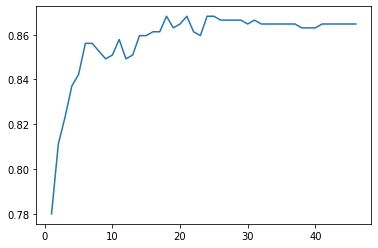

In [38]:
maxseqlen_test = max(len(lst) for lst in lst_test)
x = list(range(1,maxseqlen_test))
y = [model_evaluate(X_test[:,:a,:], Y_test) for a in x]

sns.lineplot(x=x, y=y)

# Plot accuracy vs increasing sequence length (from end)
Is the model using anything more than the previous days data to predict death? 
If the accuracy increases when using more data from the end we can assume so.

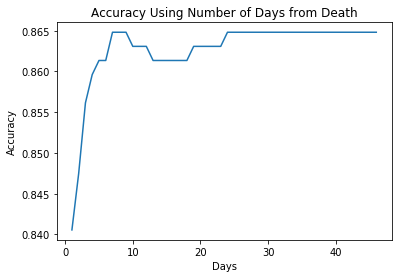

In [39]:
x = list(range(1,maxseqlen_test))
y = []

arr = np.zeros(X_test.shape)

for length in x:
    
    for index, point in enumerate(lst_test):
        r = np.array(point[::-1][:length][::-1])
        arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model_evaluate(arr, Y_test))
    
fig = sns.lineplot(x=x, y=y)
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.show(fig)

# Misclassified stats

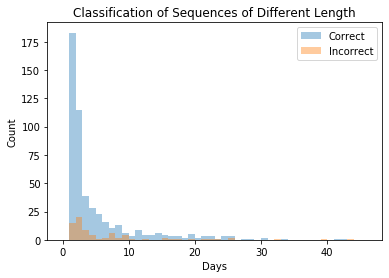

In [40]:
correct = []
incorrect = []

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        correct.append(len(lst_test[index]))
    else:
        incorrect.append(len(lst_test[index]))

sns.distplot(correct, kde=False, bins=range(max(*correct, *incorrect)), label="Correct")
fig = sns.distplot(incorrect, kde=False, bins=range(max(*correct, *incorrect)), label="Incorrect")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

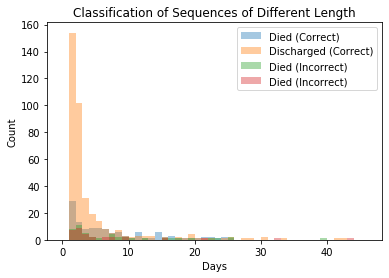

In [41]:
correct = {'Died':[], 'Discharged':[]}
incorrect = {'Died':[], 'Discharged':[]}

for index in range(len(lst_test)):
    result = model_predict(np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        if Y_test[index] == 0:
            correct['Discharged'].append(len(lst_test[index]))
        else:
            correct['Died'].append(len(lst_test[index]))
    else:
        if Y_test[index] == 0:
            incorrect['Discharged'].append(len(lst_test[index]))
        else:
            incorrect['Died'].append(len(lst_test[index]))
            
bins = range(max([y for x in list(correct.values()) + list(incorrect.values()) for y in x]))
            
sns.distplot(correct['Died'], kde=False, bins=bins, label="Died (Correct)")
sns.distplot(correct['Discharged'], kde=False, bins=bins, label="Discharged (Correct)")
sns.distplot(incorrect['Died'], kde=False, bins=bins, label="Died (Incorrect)")
fig = sns.distplot(incorrect['Discharged'], kde=False, bins=bins, label="Died (Incorrect)")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

In [42]:
..

SyntaxError: invalid syntax (<ipython-input-42-3d80792ead7e>, line 1)

In [ ]:
# optional - save model
model.save('saved_models/BinaryDeath_random_873', overwrite=False)

In [ ]:
# optional - load
model = keras.models.load_model('saved_models/BinaryDeath_random_873')

interesting thought - mask individual features?

should add comorbidities

# SHAP

Import a local version of shap in order to change a default setting for force plots. This is optional.

In [43]:
sys.path.append(os.path.join('../..', 'shap'))
import shap as shap

shap.initjs()

In [44]:
def predict(X):
    X = X.reshape((-1,1,len(X_cols)))
    return model_predict(X).flatten()

In [45]:
all_data_summary = shap.kmeans(df_test[X_cols], 10)

In [46]:
%%time
input_data = df_test[X_cols]
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(input_data)


Wall time: 35min 30s


High SHAP values -> influenced the model towards death. E.g. High age and heart rate is associated with dying.

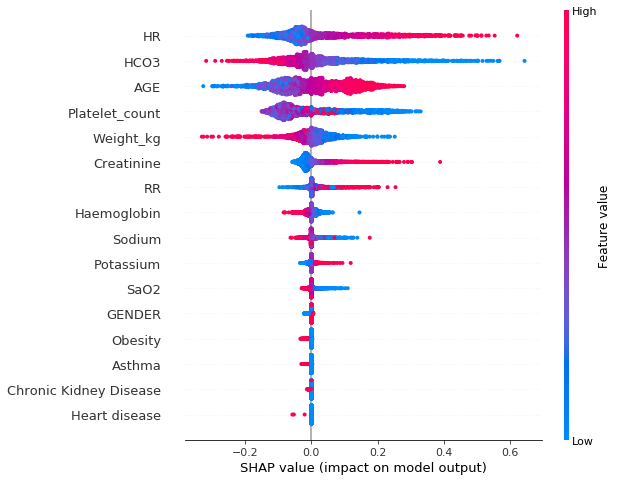

In [47]:
shap.summary_plot(shap_values, input_data)

The below shows a plot of age against the SHAP value. We can see that the age of around 65 has no effect on the model, in this case it is the average value. We also see how a high age always increases death chance, and a low age always decreases. However, this is not always the case. e.g. Heart rate can be too low or too high which will increase the shap value.

Bonus - try changing internaction_index

In [48]:
df_test['AGE'].mean()

65.58298171589311

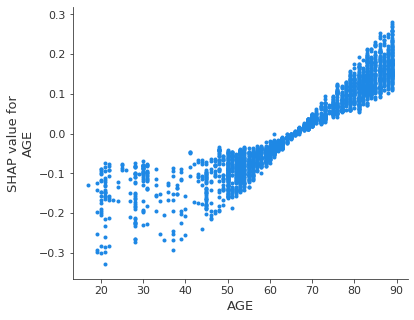

In [49]:
shap.dependence_plot('AGE', shap_values, features=input_data, interaction_index=None)

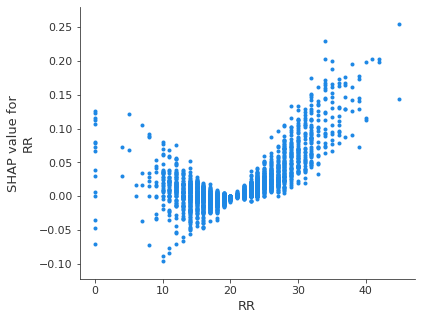

In [50]:
shap.dependence_plot('RR', shap_values, features=input_data, interaction_index=None)

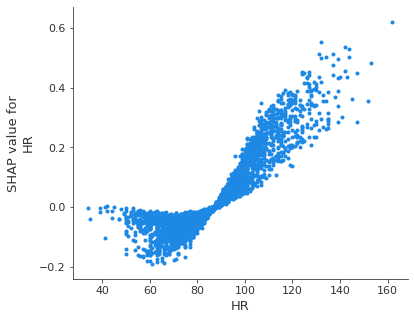

In [51]:
shap.dependence_plot('HR', shap_values, features=input_data, interaction_index=None)

## Look at evolution for an entire sequence
We can use a force plot to see how the SHAP scores change through a patients stay.

However, it's important to note that the model from SHAP only uses data from a single day.

In [52]:
seq = [0] + list(map(len, lst_test))
for i in range(len(seq)):
    if i != 0:
        seq[i] += seq[i-1]

longest_sequences_index = list(reversed(np.argsort([len(x) for x in lst_test])))

In [53]:
index = longest_sequences_index[17]

sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

Sequence length: 24
Predicted 0.9983747005462646, Actual 1


We wish to see what difference the single day data makes on the models confidence throughout the stay.

Text(0.5, 0, 'Days')

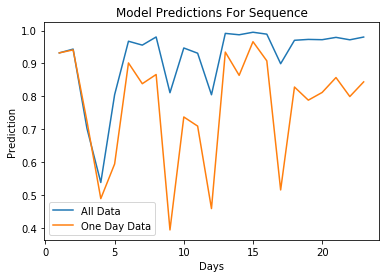

In [54]:
my_arr = lst_test[index]
x = range(1,len(my_arr))

all_data = [my_arr[:i].reshape((1,-1,len(X_cols))) for i in x]
single_day = [my_arr[i-1:i].reshape((1,-1,len(X_cols))) for i in x]

all_data = np.array([model_predict(x) for x in all_data]).reshape(-1)
single_day = np.array([model_predict(x) for x in single_day]).reshape(-1)

sns.lineplot(x=x, y=all_data, label="All Data")
sns.lineplot(x=x, y=single_day, label="One Day Data")
plt.legend()
plt.title('Model Predictions For Sequence')
plt.ylabel('Prediction')
plt.xlabel('Days')

In [55]:
index = 8
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [56]:
index = 12
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [57]:
shap.force_plot(explainer.expected_value, shap_values, input_data)

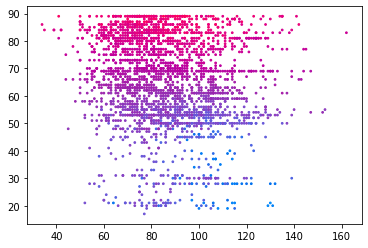

In [58]:
import matplotlib.pyplot as pl
from shap.plots import colors 

pl.scatter(input_data['HR'], input_data['AGE'], s=3,
           c=shap_values[:, X_cols.index('AGE')], cmap=colors.red_blue)

# Proper SHAP LSTM Design

This article highlights the problem with doing SHAP the way I have above, as does the `Model Predictions For Sequence` graph above. There should be no difference between the force plot from SHAP and the actual sequence predictions, however it is clear there is a difference.

https://towardsdatascience.com/interpreting-recurrent-neural-networks-on-multivariate-time-series-ebec0edb8f5a

The solution is to use a fundamental property of LSTMs - the hidden states. The solution still involves inputting a single time step at a time into SHAP. However, we now store the previous LSTM hidden states and pass them on to the next time step in the sequence. This will require some changes to the SHAP library.

In order to do this, I have made my model take two extra inputs for the hidden states and the model also gives two extra outputs for the hidden states.

For a reference implementation in pytorch, see https://github.com/AndreCNF/shap (https://github.com/slundberg/shap/compare/master...AndreCNF:master).


Need to modify how the data is passed in. Ideally, I don't want to pass in a subject ID to the model. 


`explainer.shap_values` currently takes 

```X : numpy.array or pandas.DataFrame or any scipy.sparse matrix
    A matrix of samples (# samples x # features) on which to explain the model's output.
```
    
This could be changed to pass in a list of samples, such as [(# timesteps x # features), ...]. Note this is instead of a 3d array, since timesteps can be of different lengths. E.g. see variable lst_test. If this is done, the output should should also be 3d.

An alternative is to add an extra input which connects elements in the sequence together. (e.g. the HADM_ID slice in the dataframe). This should reduce the amount of code that needs to be changed.